In [38]:
import os
import re
import string
import numpy as np
import gensim 
from itertools import chain
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM,Input, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,GRU, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import nltk.data
from sklearn.metrics import accuracy_score
PATH_TO_DATA="data/aclImdb"
PATH_TO_GLOVE_100="data/glove/glove.6B.100d.txt"
PATH_TO_GLOVE_300="data/glove/glove.6B.300d.txt"
VOCAB_SIZE=5000
EMBEDDING_VOCAB_SIZE=VOCAB_SIZE+3
REVIEW_MAX_LEN=500

In [4]:
def load_file(filename):
    with open(filename, 'r', encoding="utf8") as file:
        text = file.read()
    return text

def preprocess(review):
    review = review.lower()
    regx = re.compile('<[^<>]+>')
    review = regx.sub(repl=' ', string=review)
    regx = re.compile(r"(http|https)://[^\s]*")
    review, nhttps = regx.subn(repl="", string=review)
    regx = re.compile(r"\b[^\s]+@[^\s]+[.][^\s]+\b")
    review, nemails = regx.subn(repl="", string=review)
    regx = re.compile(r"[\d.]+")
    review = regx.sub(repl="", string=review)
    regx = re.compile(r"([^\w\s]+)|([_-]+)")  
    review = regx.sub(repl=" ", string=review)
    regx = re.compile(r"\n\n")
    review = regx.sub(repl=" ", string=review)
    regx = re.compile(r"\n")
    review = regx.sub(repl=" ", string=review)
    regx = re.compile(r"\s+")
    review = regx.sub(repl=" ", string=review)
    tokens = review.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    stemmer = SnowballStemmer("english")
    stemwords = [stemmer.stem(wd) for wd in tokens]
    return " ".join(stemwords)

def add_review_to_vocab(review_fname, vocab):
    review = load_file(review_fname)
    tokens = preprocess(review)
    vocab.update(tokens)
 
def process_reviews(directory, vocab):
    for filename in listdir(directory):
        path = directory + '/' + filename
        add_review_to_vocab(path, vocab)

In [5]:
vocab = Counter()
reviews_processed_train=[]
y_train=[]
for sentiment in ["pos", "neg"]:
    for fname in listdir(f"{PATH_TO_DATA}/train/{sentiment}"):
        review=preprocess(load_file(f"{PATH_TO_DATA}/train/{sentiment}/{fname}"))
        reviews_processed_train.append(review)
        vocab.update(review.split(" "))
        y_train.append(1 if sentiment=="pos" else 0)
y_train = np.array(y_train)
reviews_processed_test=[]
y_test=[]
for sentiment in ["pos", "neg"]:
    for fname in listdir(f"{PATH_TO_DATA}/test/{sentiment}"):
        review=preprocess(load_file(f"{PATH_TO_DATA}/test/{sentiment}/{fname}"))
        reviews_processed_test.append(review)
        vocab.update(review.split(" "))
        y_test.append(1 if sentiment=="pos" else 0)
y_test = np.array(y_test)
print(vocab.most_common(20))

[('movi', 102716), ('film', 95564), ('one', 55259), ('like', 45116), ('time', 31806), ('good', 30072), ('make', 30013), ('charact', 28288), ('see', 28183), ('get', 27945), ('watch', 27787), ('even', 25296), ('stori', 25222), ('would', 24596), ('realli', 23060), ('well', 21421), ('scene', 21398), ('look', 19912), ('show', 19858), ('bad', 19730)]


In [21]:
def transform_reviews(reviews_train, reviews_test, vocab_size=5000, start_char=1, oov_char=2, index_from=3):
    vocab = Counter()
    for review in chain(reviews_train, reviews_test):
        vocab.update(review.split(" "))
    vocab_entries_idxies={
        word_info[0]: idx for idx, word_info in enumerate(vocab.most_common(vocab_size))
    }
    reviews_numerized = []
    for review in chain(reviews_train, reviews_test):
        review_numerized=[start_char]
        for word in review.split(" "):
            if word not in vocab_entries_idxies:
                review_numerized.append(oov_char)
            else:
                review_numerized.append(index_from+vocab_entries_idxies[word])
        reviews_numerized.append(review_numerized)
    x_train = np.array([np.array(review) for review in reviews_numerized[:len(reviews_train)]])
    x_test = np.array([np.array(review) for review in reviews_numerized[len(reviews_train):]])
    return x_train, x_test, vocab_entries_idxies

In [22]:
X_train, X_test, vocab_indexes=transform_reviews(reviews_processed_train, reviews_processed_test, vocab_size=VOCAB_SIZE)

In [14]:
X_train = sequence.pad_sequences(X_train, maxlen=REVIEW_MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=REVIEW_MAX_LEN)

In [72]:
def plot_history(history):
    if 'accuracy' in history.history:
        plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
        plt.subplot(211)
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.subplot(212)
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='test')
        plt.legend()
    else:
        plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
    plt.show()

In [71]:
def create_and_evaluate_model(embedding_layer, max_epochs=20, lstm_units=64):
    model=Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)]
    model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
    history=model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=max_epochs, callbacks=callbacks, shuffle=True)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test loss={loss}, accuracy={accuracy}")
    return loss, accuracy, history

In [9]:
embedding_size=128

In [12]:
embedding_size=128
loss, accuracy, history=create_and_evaluate_model(Embedding(EMBEDDING_VOCAB_SIZE, embedding_size, input_length=REVIEW_MAX_LEN))
print(f"Model loss={loss}, accuracy={accuracy}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 710s 35ms/sample - loss: 0.4567 - accuracy: 0.7897 - val_loss: 1.5710 - val_accuracy: 0.3274
Epoch 2/20
20000/20000 [==============================] - 757s 38ms/sample - loss: 0.3502 - accuracy: 0.8565 - val_loss: 0.4462 - val_accuracy: 0.7538
Epoch 3/20
20000/20000

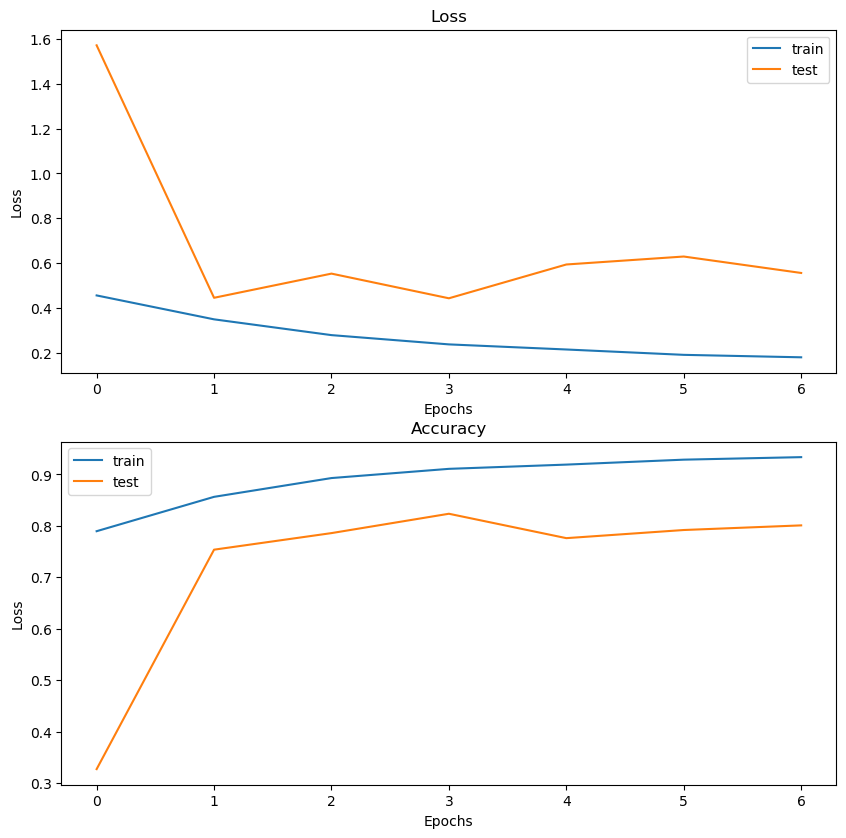

In [13]:
plot_history(history)

In [27]:
tokenizer = Tokenizer(nb_words=REVIEW_MAX_LEN)
X_train_tok = tokenizer.sequences_to_matrix([x.tolist() for x in X_train], mode='binary')
X_test_tok = tokenizer.sequences_to_matrix([x.tolist() for x in X_test], mode='binary')

In [73]:
NUMBER_OF_ENCODER_LAYERS=3

In [94]:
def get_encoder(input_sent):
    encoded = Dense(1024, activation='relu')(input_sent)
    x = Dense(512, activation='relu')(encoded)
    x = Dense(256, activation='relu')(x)
    return x

def get_decoder(encoder_last_l, output_len):
    x = Dense(256, activation='relu')(encoder_last_l)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(output_len, activation='relu')(x)
    return decoded

In [105]:
def get_autoencoder(input_sent, output_len):
    autoencoder=Model(input_sent, get_decoder(get_encoder(input_sent), output_len))
    autoencoder.compile(loss='binary_crossentropy', 
             optimizer='adam', metrics=['accuracy'])
    return autoencoder

In [106]:
input_sent=Input(shape = (REVIEW_MAX_LEN,))
autoencoder=get_autoencoder(input_sent, REVIEW_MAX_LEN)

In [107]:
autoencoder.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              513024    
_________________________________________________________________
dense_40 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_43 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_44 (Dense)             (None, 500)             

In [108]:
def evaluate_model(model, X_train, y_train, X_test, y_test, max_epochs=50, lstm_units=64):
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]
    history=model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=max_epochs, callbacks=callbacks, shuffle=True)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss={loss}, accuracy={accuracy}')
    return history

In [109]:
history=evaluate_model(autoencoder, X_train_tok, X_train_tok, X_test_tok, X_test_tok)

Epoch 1/50
157/157 [==============================] - 2s 11ms/step - loss: 0.4883 - accuracy: 0.7508 - val_loss: 0.4666 - val_accuracy: 1.0000
Epoch 2/50
157/157 [==============================] - 2s 10ms/step - loss: 0.4540 - accuracy: 1.0000 - val_loss: 0.4455 - val_accuracy: 1.0000
Epoch 3/50
157/157 [==============================] - 2s 11ms/step - loss: 0.4259 - accuracy: 1.0000 - val_loss: 0.4375 - val_accuracy: 1.0000
Epoch 4/50
157/157 [==============================] - 2s 10ms/step - loss: 0.4211 - accuracy: 1.0000 - val_loss: 0.4374 - val_accuracy: 1.0000
Epoch 5/50
157/157 [==============================] - 2s 11ms/step - loss: 0.4209 - accuracy: 1.0000 - val_loss: 0.4321 - val_accuracy: 1.0000
Epoch 6/50
157/157 [==============================] - 2s 10ms/step - loss: 0.4241 - accuracy: 1.0000 - val_loss: 0.4341 - val_accuracy: 1.0000
Epoch 7/50
157/157 [==============================] - 2s 10ms/step - loss: 0.4194 - accuracy: 1.0000 - val_loss: 0.4360 - val_accuracy: 1.0000

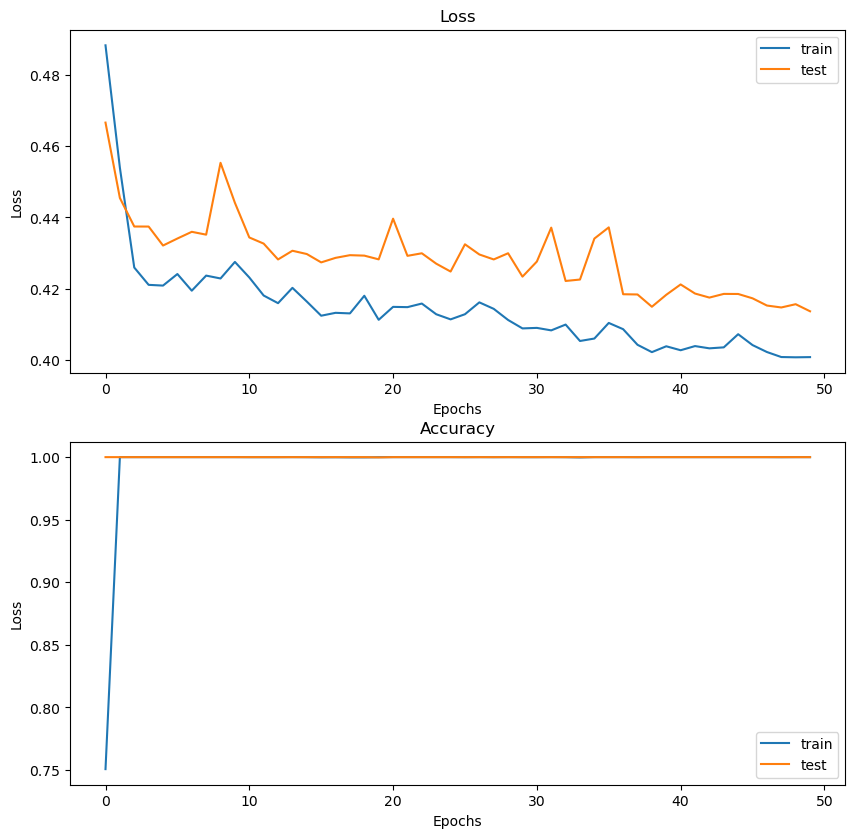

In [110]:
plot_history(history)

In [111]:
def get_fully_connected_model_with_encoder(input_sent, num_of_encoder_layers=1):
    encoder = get_encoder(input_sent)
    x = Dense(512, activation='relu')(encoder)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(encoder)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    full_model = Model(input_sent, out)
    return full_model

def set_model_weights(full_model, encoder, num_of_encoder_layers=1):
    for l1,l2 in zip(full_model.layers[:num_of_encoder_layers], encoder.layers[0:num_of_encoder_layers]):
        l1.set_weights(l2.get_weights())
    for layer in full_model.layers[0:num_of_encoder_layers]:
        layer.trainable = False
    return full_model

In [112]:
fc_with_encoder=get_fully_connected_model_with_encoder(input_sent, NUMBER_OF_ENCODER_LAYERS)
set_model_weights(fc_with_encoder, autoencoder, NUMBER_OF_ENCODER_LAYERS)
fc_with_encoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fc_with_encoder.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              513024    
_________________________________________________________________
dense_46 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_49 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)               

In [113]:
history=evaluate_model(fc_with_encoder, X_train_tok, y_train.reshape(-1, 1), X_test_tok, y_test.reshape(-1, 1))

Epoch 1/50
157/157 [==============================] - 1s 6ms/step - loss: 0.4733 - accuracy: 0.7764 - val_loss: 0.6080 - val_accuracy: 0.6734
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4520 - accuracy: 0.7899 - val_loss: 0.5701 - val_accuracy: 0.6946
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4434 - accuracy: 0.7930 - val_loss: 0.5718 - val_accuracy: 0.6904
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4389 - accuracy: 0.7958 - val_loss: 0.5646 - val_accuracy: 0.6800
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4357 - accuracy: 0.7964 - val_loss: 0.5677 - val_accuracy: 0.7090
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4278 - accuracy: 0.8036 - val_loss: 0.4732 - val_accuracy: 0.7492
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8045 - val_loss: 0.6454 - val_accuracy: 0.6472
Epoch 

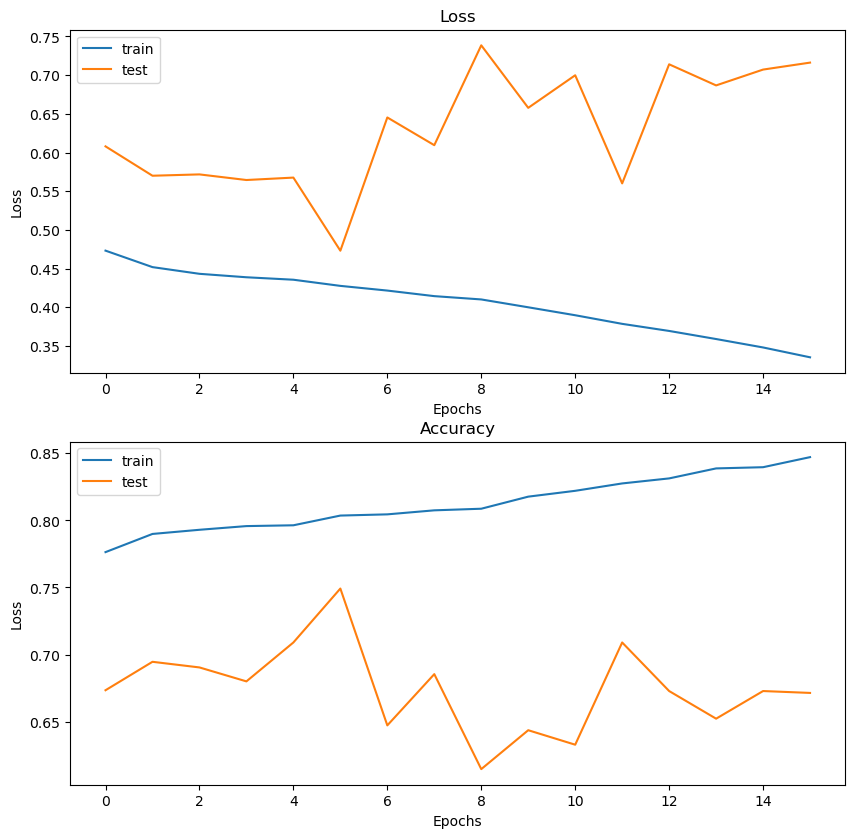

In [114]:
plot_history(history)

In [115]:
def make_layers_trainable(full_model, num_of_encoder_layers=1):
    for layer in full_model.layers[:num_of_encoder_layers]:
        layer.trainable = True

In [116]:
make_layers_trainable(fc_with_encoder, NUMBER_OF_ENCODER_LAYERS)
history=evaluate_model(fc_with_encoder, X_train_tok, y_train.reshape(-1, 1), X_test_tok, y_test.reshape(-1, 1))

Epoch 1/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.8066 - val_loss: 0.6008 - val_accuracy: 0.6882
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 0.4113 - accuracy: 0.8093 - val_loss: 0.6012 - val_accuracy: 0.6868
Epoch 3/50
157/157 [==============================] - 1s 4ms/step - loss: 0.4021 - accuracy: 0.8138 - val_loss: 0.6542 - val_accuracy: 0.6518
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3973 - accuracy: 0.8191 - val_loss: 0.7281 - val_accuracy: 0.6332
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3899 - accuracy: 0.8220 - val_loss: 0.5709 - val_accuracy: 0.7132
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3853 - accuracy: 0.8225 - val_loss: 0.7223 - val_accuracy: 0.6256
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 0.3767 - accuracy: 0.8278 - val_loss: 0.7375 - val_accuracy: 0.6322
Epoch 

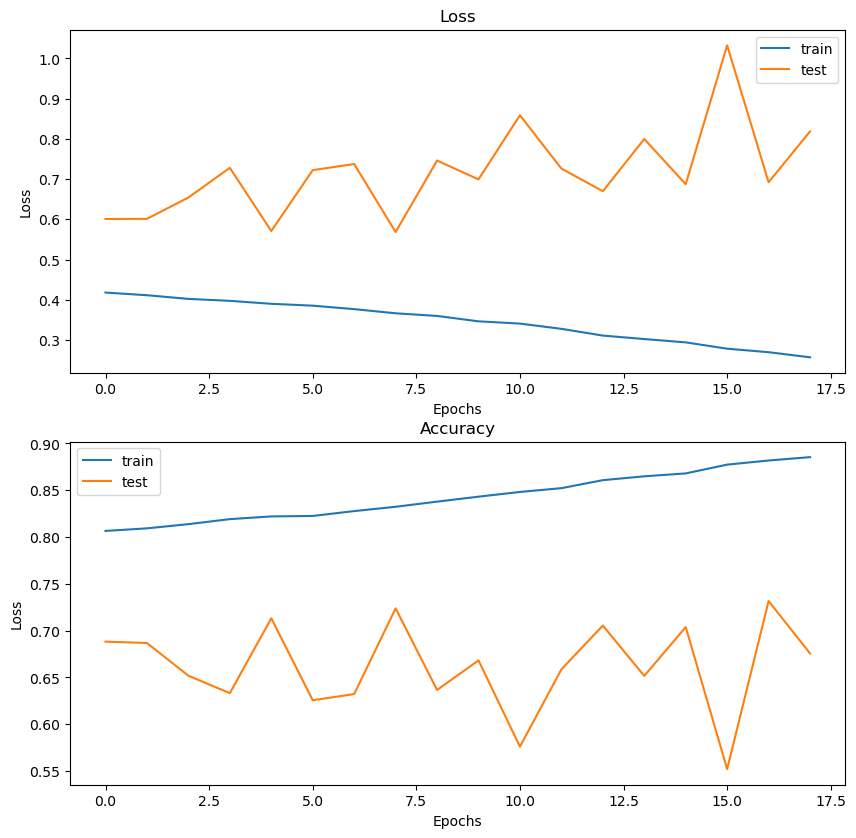

In [117]:
plot_history(history)